# Maybe I should call the package the DEFIANT?

**D**ata-driven **E**nhanced **F**requentist **I**nference **A**nalysis with **N**ext-gen **T**echniques

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')
sys.path.append('../../PerFreqOS')

from OSplusplus import OSplusplus
from OSplusplus import utils

from PFOS.optimal_statistic import OptimalStatistic
from PFOS.pfos_functions import compute_normPFOS, compute_radPFOS, compute_normNMPFOS
from PFOS.psr_pair_covariance import pair_covariant_OS, pair_covariant_normPFOS

## Load up MDC1 pulsars and CURN PTA

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14),'gw_gamma':(13./3.)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

lfcore_loc = 'MDC1_FG_CURN_samples.core'
lfcore = Core(corepath=lfcore_loc)

Loading data from HDF5 file....


In [4]:
# A handy function to take the percent difference between elements

def minmax_percent_diff(true,test):
    """Get the minimum and maximum percent difference of the elements (test-true)/true"""
    temp = np.abs(test-true)/true
    return np.min(temp),np.max(temp)




xi_range = np.linspace(0.01,np.pi,1000)
hd_cor = utils.orf_xi(xi_range,'hd')
dp_cor = utils.orf_xi(xi_range,'dipole')
mp_cor = utils.orf_xi(xi_range,'monopole')


## Create an older OS object and a new OS++ object

In [5]:
old_os = OptimalStatistic(psrs,pta=pta)

new_os = OSplusplus(psrs,pta,'gw',core=lfcore)

#### Traditional OS

min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rho]: (-5.261740541901247e-11, 2.370886507735983e-10)
min and max percent difference [sig]: (0.0, 1.2888122522517395e-15)
min and max percent difference [A2]: (2.285169816469709e-13, 2.285169816469709e-13)
min and max percent difference [A2s]: (1.1745032123349341e-16, 1.1745032123349341e-16)


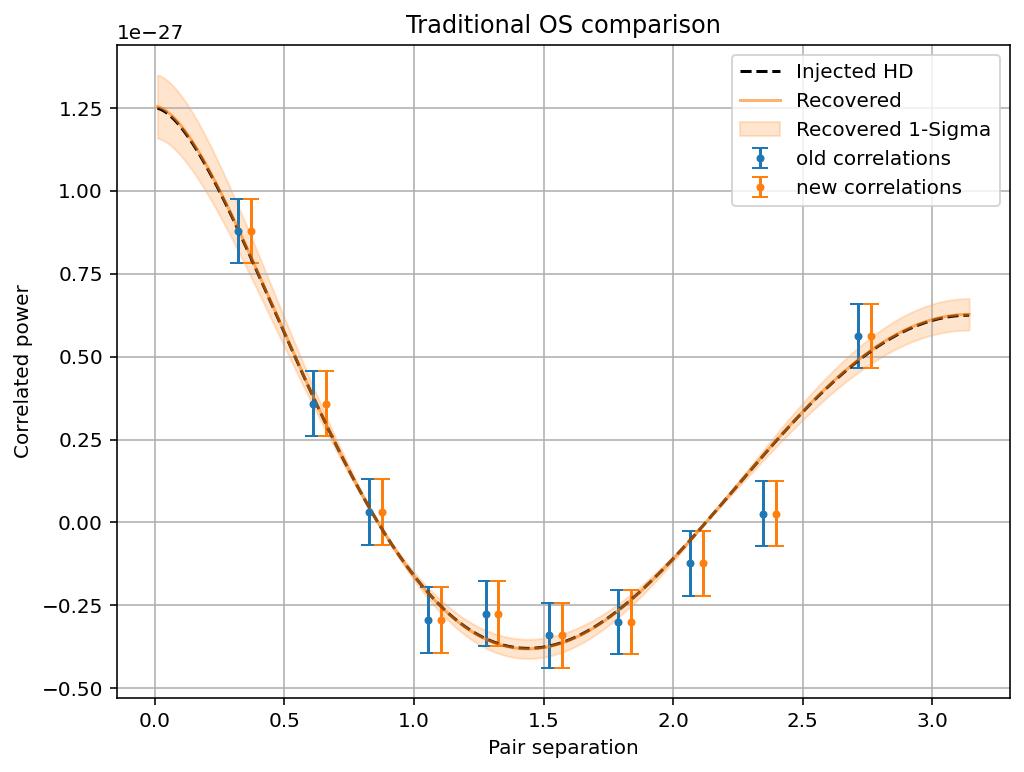

In [6]:
old_xi,old_rho,old_sig,old_A2,old_A2s = old_os.compute_os(inj_params)

xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=False)

# Print differences
print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rho]:',minmax_percent_diff(old_rho,rho))
print('min and max percent difference [sig]:',minmax_percent_diff(old_sig,sig))
print('min and max percent difference [A2]:',minmax_percent_diff(old_A2,A2))
print('min and max percent difference [A2s]:',minmax_percent_diff(old_A2s,A2s))

# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,sig,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2*hd_cor,'-C1',alpha=0.6,label='Recovered')
plt.fill_between(xi_range,(A2-A2s)*hd_cor,(A2+A2s)*hd_cor,color='C1',alpha=0.2,
                 label='Recovered 1-Sigma')

plt.title('Traditional OS comparison')
plt.xlabel('Pair separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

#### Pair Covariant OS

Pairs of pairs: 100%|███████████████| 198765/198765 [00:00<00:00, 595912.81it/s]


min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rho]: (-5.261740541901247e-11, 2.370886507735983e-10)
min and max percent difference [C]: (-2.710518856842176e-14, 1.0806158223254641e-13)
min and max percent difference [A2]: (4.4950895683325914e-13, 4.4950895683325914e-13)
min and max percent difference [A2s]: (5.178084475722463e-16, 5.178084475722463e-16)


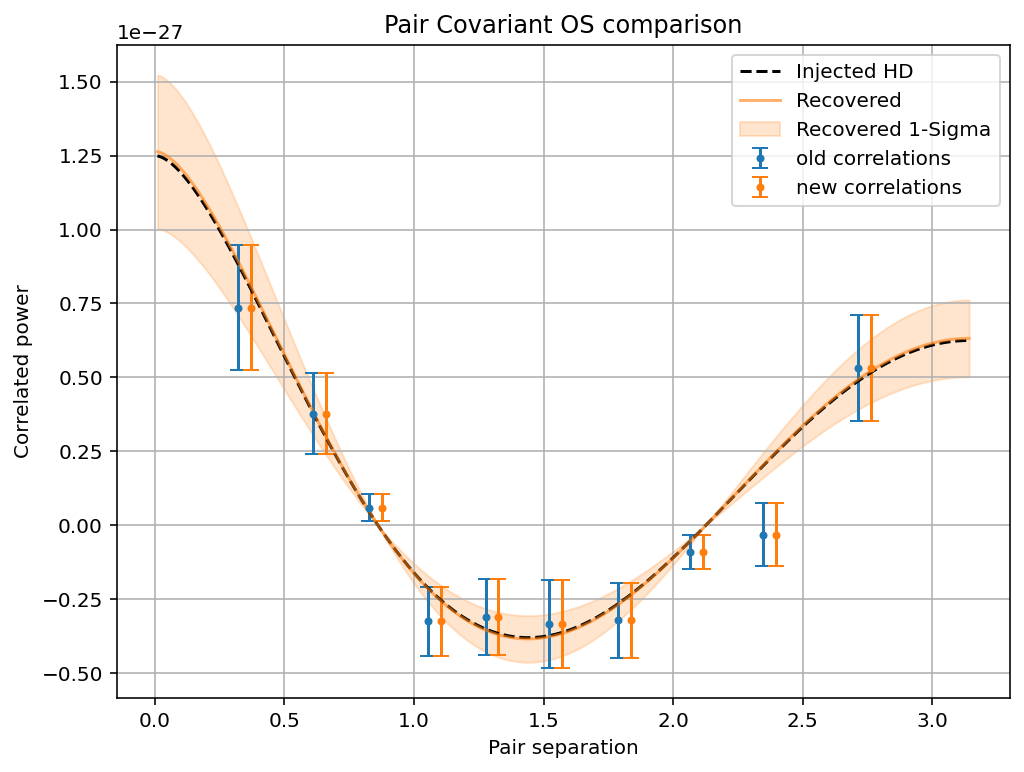

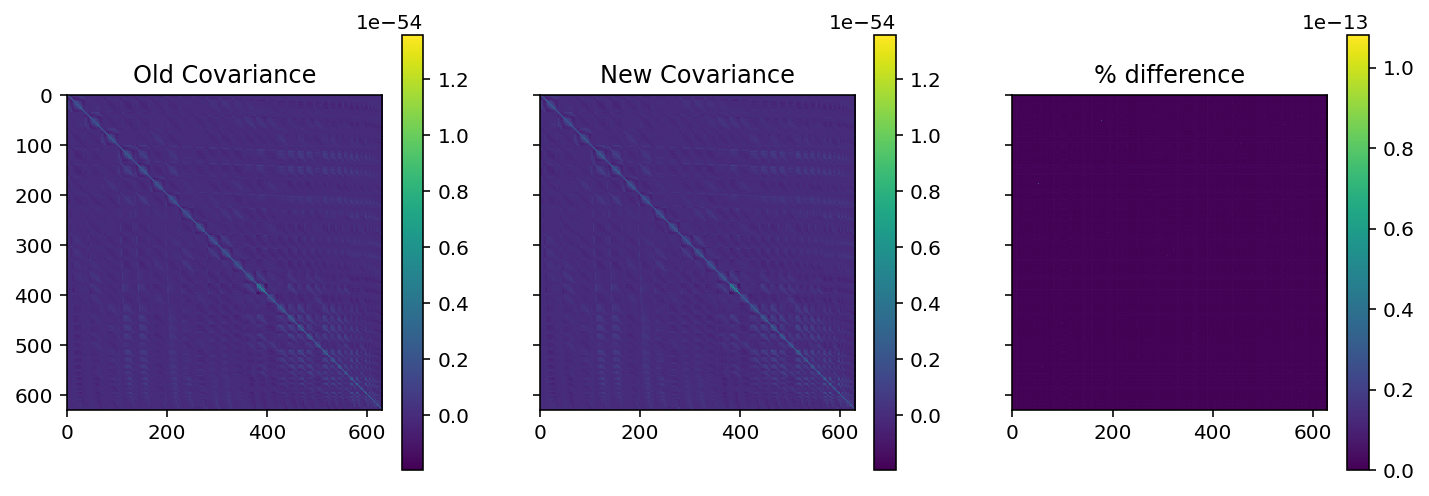

In [7]:
old_xi,old_rho,old_sig,old_A2,old_A2s = pair_covariant_OS(old_os,inj_params)

xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=True)

# Print differences
print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rho]:',minmax_percent_diff(old_rho,rho))
print('min and max percent difference [C]:',minmax_percent_diff(old_sig,C))
print('min and max percent difference [A2]:',minmax_percent_diff(old_A2,A2))
print('min and max percent difference [A2s]:',minmax_percent_diff(old_A2s,A2s))

# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_covariant_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_covariant_correlations(xi,rho,C,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2*hd_cor,'-C1',alpha=0.6,label='Recovered')
plt.fill_between(xi_range,(A2-A2s)*hd_cor,(A2+A2s)*hd_cor,color='C1',alpha=0.2,
                 label='Recovered 1-Sigma')

plt.title('Pair Covariant OS comparison')
plt.xlabel('Pair separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

# Plot the covariance matrix
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
img = ax[0].imshow(old_sig)
fig.colorbar(img)
ax[0].set_title('Old Covariance')

img = ax[1].imshow(C)
ax[1].set_title('New Covariance')
fig.colorbar(img)

img = ax[2].imshow(np.abs((C-old_sig)/old_sig))
ax[2].set_title('% difference')
fig.colorbar(img)


plt.show()

#### MCOS

min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rho]: (-5.261740541901247e-11, 2.370886507735983e-10)
min and max percent difference [sig]: (0.0, 1.2888122522517395e-15)
min and max percent difference [mcos_A2]: (-3.668139124287212e-13, 6.708782990470634e-12)
min and max percent difference [mcos_A2s]: (1.1375008687035544e-16, 2.234484892986085e-16)


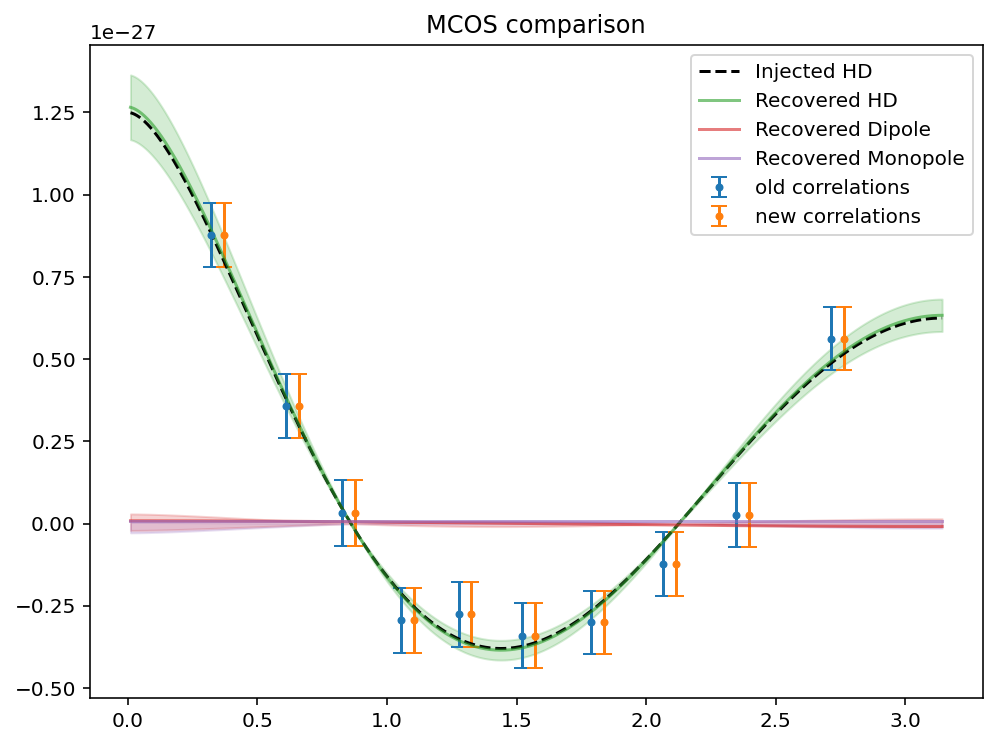

In [8]:
old_xi,old_rho,old_sig,old_A2,old_A2s = old_os.compute_multiple_corr_os(inj_params,
                                            correlations=['hd','dipole','monopole'])

new_os.set_orf(['hd','dipole','monopole'])
xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=False)
new_os.set_orf('hd')

# Print differences
print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rho]:',minmax_percent_diff(old_rho,rho))
print('min and max percent difference [sig]:',minmax_percent_diff(old_sig,sig))
print('min and max percent difference [mcos_A2]:',minmax_percent_diff(old_A2,A2))
print('min and max percent difference [mcos_A2s]:',minmax_percent_diff(old_A2s,np.sqrt(np.diag(A2s))))


# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,sig,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2[0]*hd_cor,'-C2',alpha=0.6,label='Recovered HD')
plt.fill_between(xi_range,
                 (A2[0]-np.sqrt(A2s[0,0]))*hd_cor,
                 (A2[0]+np.sqrt(A2s[0,0]))*hd_cor,
                 color='C2',alpha=0.2)
plt.plot(xi_range,A2[1]*dp_cor,'-C3',alpha=0.6,label='Recovered Dipole')
plt.fill_between(xi_range,
                 (A2[1]-np.sqrt(A2s[1,1]))*hd_cor,
                 (A2[1]+np.sqrt(A2s[1,1]))*hd_cor,
                 color='C3',alpha=0.2)
plt.plot(xi_range,A2[1]*mp_cor,'-C4',alpha=0.6,label='Recovered Monopole')
plt.fill_between(xi_range,
                 (A2[2]-np.sqrt(A2s[2,2]))*hd_cor,
                 (A2[2]+np.sqrt(A2s[2,2]))*hd_cor,
                 color='C4',alpha=0.2)

plt.title('MCOS comparison')
plt.legend()
plt.show()

#### NMOS with traditional OS

In [9]:
_,_,_,old_A2,old_A2s = old_os.compute_noise_marginalized_os(chain=lfcore.chain,
                                                            param_names=lfcore.params,
                                                            N=10000)

A2,A2s,idx = new_os.compute_OS(N=10000,pair_covariance=False,return_pair_vals=False)

/Users/gersbaka/Documents/Projects/OSplusplus/Notebooks/../../PerFreqOS/PFOS/optimal_statistic.py:163: UserWarning: MCMC chain does not have the same number of parameters as the model.
100%|██████████| 10000/10000 [01:10<00:00, 142.06it/s]


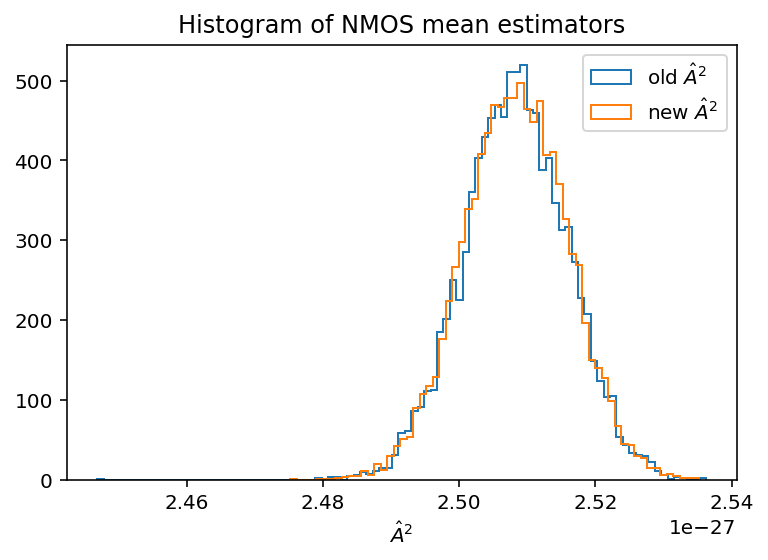

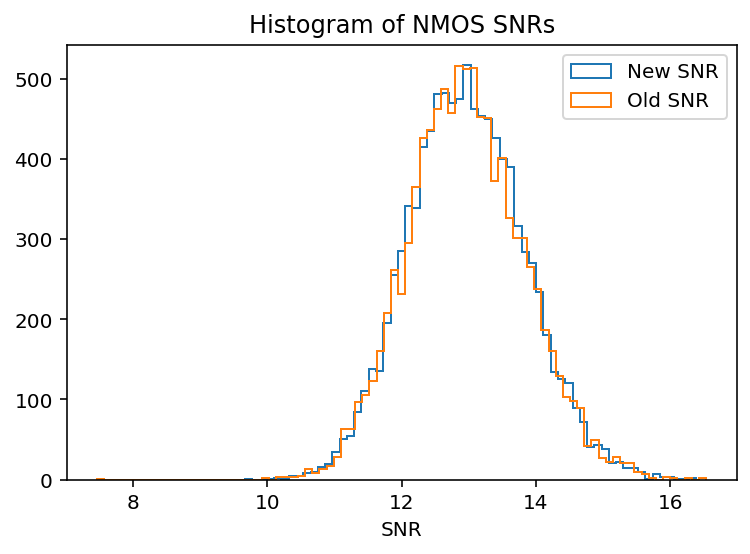

In [10]:
plt.hist(old_A2,bins='auto',histtype='step',label='old $\hat{A}^2$')
plt.hist(A2,bins='auto',histtype='step',label='new $\hat{A}^2$')
plt.xlabel('$\hat{A}^2$')
plt.legend()
plt.title('Histogram of NMOS mean estimators')
plt.show()

plt.hist(A2/A2s,'auto',histtype='step',label='New SNR')
plt.hist(old_A2/old_A2s,'auto',histtype='step',label='Old SNR')
plt.xlabel('SNR')
plt.legend()
plt.title('Histogram of NMOS SNRs')
plt.show()

### Comparing Narrowband PFOS

min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rhok]: (-1.3138512715992208e-09, 1.0268943549964123e-09)
min and max percent difference [sigk]: (0.0, 3.132152898574335e-16)
min and max percent difference [Sk]: (-5.85868064019513e-13, 5.914989035510341e-12)
min and max percent difference [Sks]: (0.0, 2.097291195155568e-16)


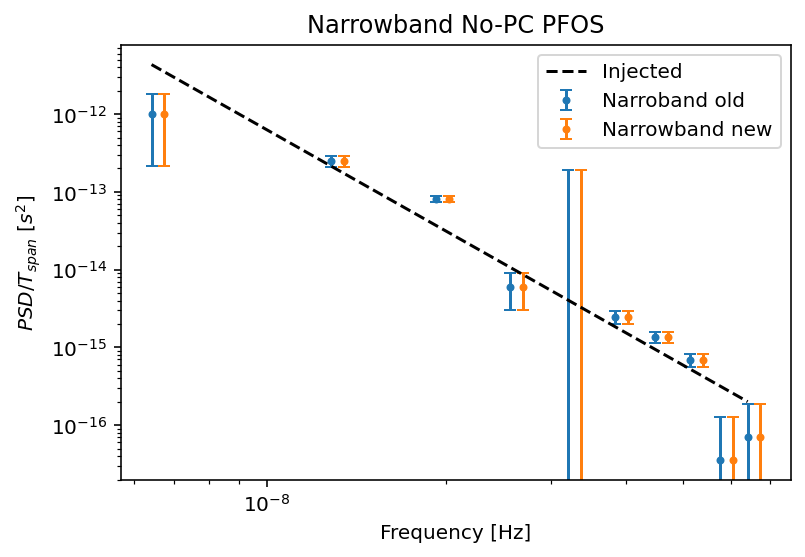

In [11]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = compute_radPFOS(old_os,inj_params)
plt.errorbar(fgw, old_Sk, old_Sks, fmt='.',capsize=3,label='Narroband old')

xi,rhok,sigk,Ck,Sk,Sks = new_os.compute_PFOS(inj_params,pair_covariance=False,narrowband=True,use_tqdm=False)
plt.errorbar(new_os.freqs+new_os.freqs/20, Sk, Sks, fmt='.',capsize=3,label='Narrowband new')

print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rhok]:',minmax_percent_diff(old_rhok,rhok))
print('min and max percent difference [sigk]:',minmax_percent_diff(old_sigk,sigk))
print('min and max percent difference [Sk]:',minmax_percent_diff(old_Sk,Sk))
print('min and max percent difference [Sks]:',minmax_percent_diff(old_Sks,Sks))


inj_psd = powerlaw(new_os.freqs, inj_params['gw_log10_A'], inj_params['gw_gamma'],1)
plt.plot(new_os.freqs,inj_psd,'--k',label='Injected')

plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.ylabel('$PSD/T_{span}$ [$s^2$]')
plt.title('Narrowband No-PC PFOS')
plt.legend()
plt.show()

### Comparing Broadband PFOS

min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rhok]: (-1.3138504350230996e-09, 1.0268947539622438e-09)
min and max percent difference [sigk]: (0.0, 2.0467432355832282e-13)
min and max percent difference [Sk]: (-4.157966995805855e-12, 5.918931115143559e-12)
min and max percent difference [Sks]: (0.0, 1.6992874871197107e-16)


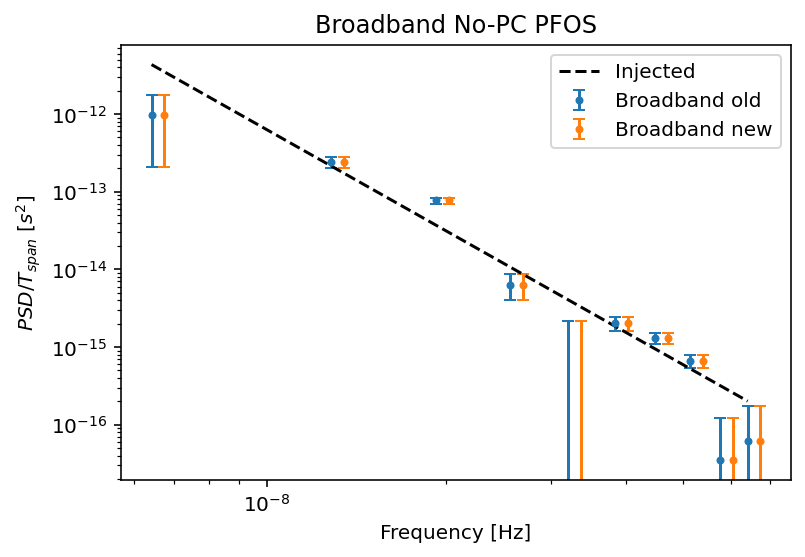

In [12]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = compute_normPFOS(old_os,inj_params)
plt.errorbar(fgw, old_Sk, old_Sks, fmt='.',capsize=3,label='Broadband old')

xi,rhok,sigk,Ck,Sk,Sks = new_os.compute_PFOS(inj_params,pair_covariance=False,use_tqdm=False)
plt.errorbar(new_os.freqs+new_os.freqs/20, Sk, Sks, fmt='.',capsize=3,label='Broadband new')

print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rhok]:',minmax_percent_diff(old_rhok,rhok))
print('min and max percent difference [sigk]:',minmax_percent_diff(old_sigk,sigk))
print('min and max percent difference [Sk]:',minmax_percent_diff(old_Sk,Sk))
print('min and max percent difference [Sks]:',minmax_percent_diff(old_Sks,Sks))


inj_psd = powerlaw(new_os.freqs, inj_params['gw_log10_A'], inj_params['gw_gamma'],1)
plt.plot(new_os.freqs,inj_psd,'--k',label='Injected')

plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.ylabel('$PSD/T_{span}$ [$s^2$]')
plt.title('Broadband No-PC PFOS')
plt.legend()
plt.show()

### Comparing pair covariant broadband PFOS

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


min and max percent difference [xi]: (0.0, 0.0)
min and max percent difference [rhok]: (-1.3138504350230996e-09, 1.0268947539622438e-09)
min and max percent difference [Ck]: (-2.147006199648157e-10, 7.723171217893726e-11)
min and max percent difference [Sk]: (-2.4833784155003567e-12, 3.1710623635033497e-12)
min and max percent difference [Sks]: (0.0, 5.178362950318093e-15)


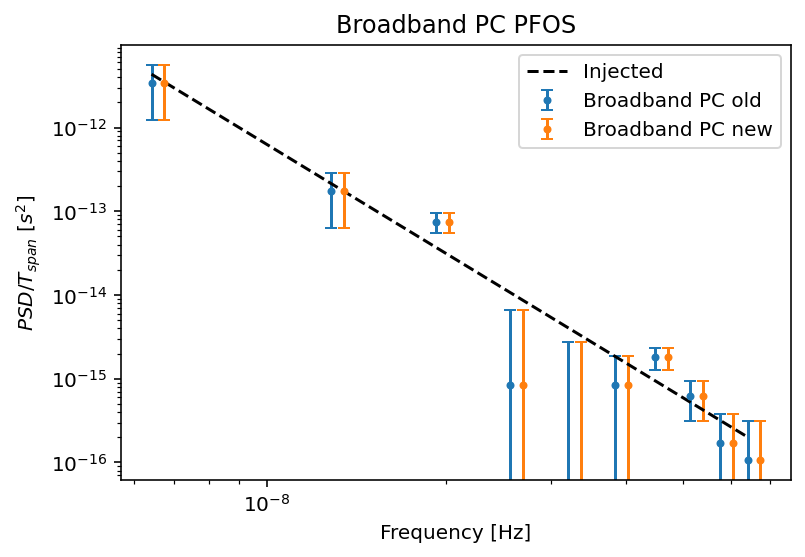

In [13]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = pair_covariant_normPFOS(old_os,inj_params)
plt.errorbar(fgw, old_Sk, old_Sks, fmt='.',capsize=3,label='Broadband PC old')

xi,rhok,sigk,Ck,Sk,Sks = new_os.compute_PFOS(inj_params,use_tqdm=False)
plt.errorbar(new_os.freqs+new_os.freqs/20, Sk, Sks, fmt='.',capsize=3,label='Broadband PC new')

print('min and max percent difference [xi]:',minmax_percent_diff(old_xi,xi))
print('min and max percent difference [rhok]:',minmax_percent_diff(old_rhok,rhok))
print('min and max percent difference [Ck]:',minmax_percent_diff(old_sigk,Ck))
print('min and max percent difference [Sk]:',minmax_percent_diff(old_Sk,Sk))
print('min and max percent difference [Sks]:',minmax_percent_diff(old_Sks,Sks))


inj_psd = powerlaw(new_os.freqs, inj_params['gw_log10_A'], inj_params['gw_gamma'],1)
plt.plot(new_os.freqs,inj_psd,'--k',label='Injected')

plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.ylabel('$PSD/T_{span}$ [$s^2$]')
plt.title('Broadband PC PFOS')
plt.legend()
plt.show()

### And one more test, noise marginalized Broadband No PC PFOS

In [14]:
_,_,_,old_Sk,old_Sks,fgw = compute_normNMPFOS(old_os,lfcore.chain,lfcore.params,N=1000)

Sk,Sks,idx = new_os.compute_PFOS(N=1000,pair_covariance=False,return_pair_vals=False)


100%|██████████| 1000/1000 [00:30<00:00, 33.16it/s]


min and max percent difference [Sk]: (-0.23548803156780979, 0.07758692429387792)
min and max percent difference [Sks]: (4.2337641277447876e-05, 0.3258232073292828)


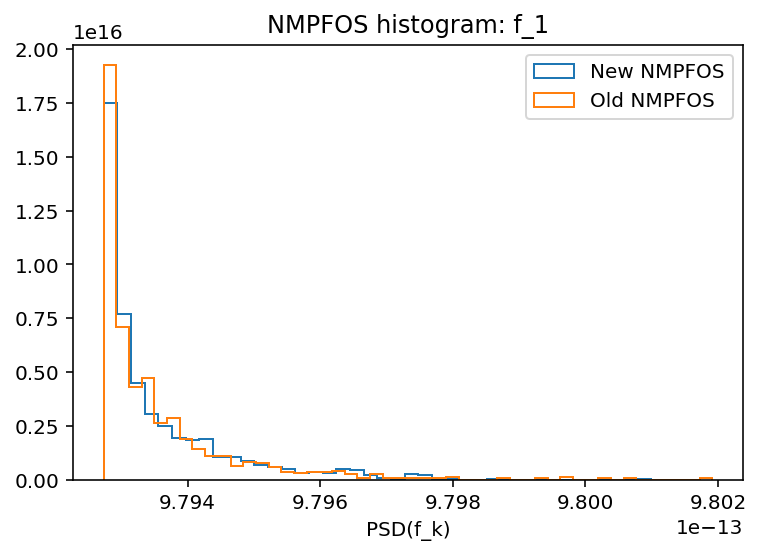

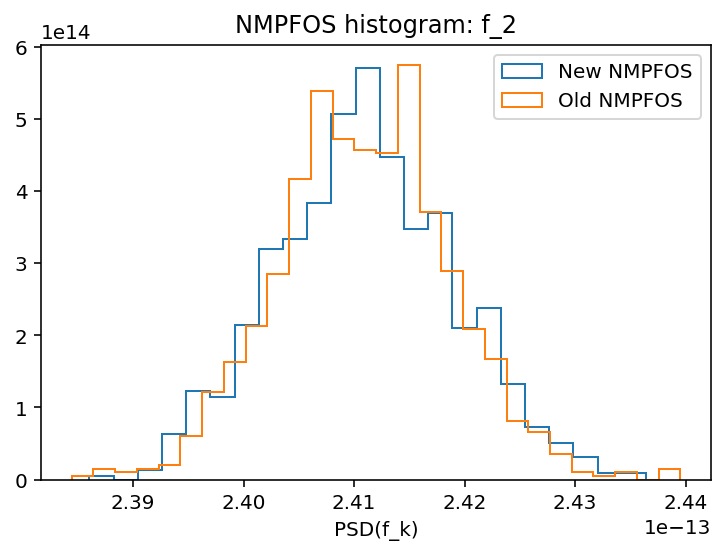

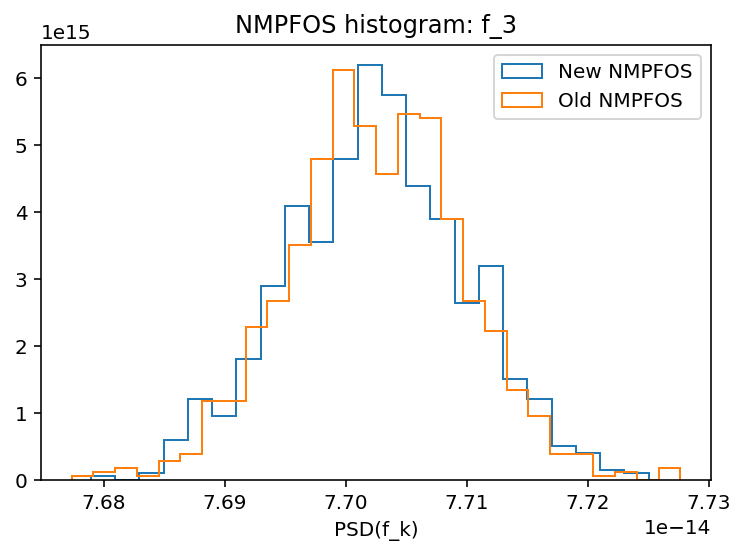

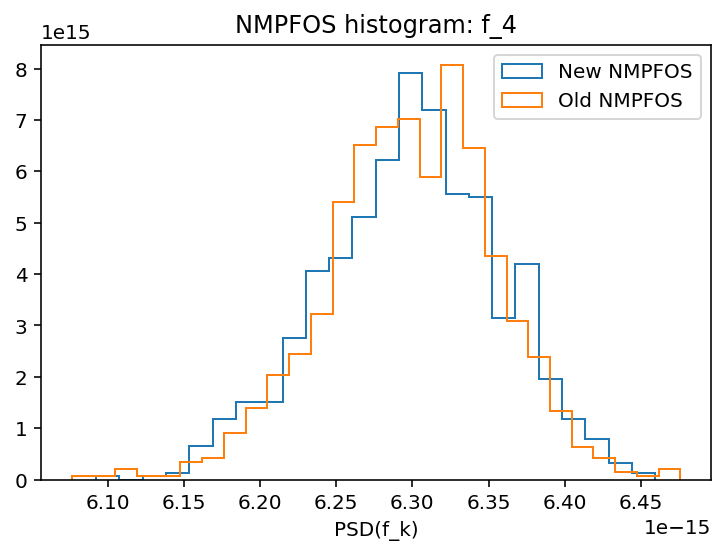

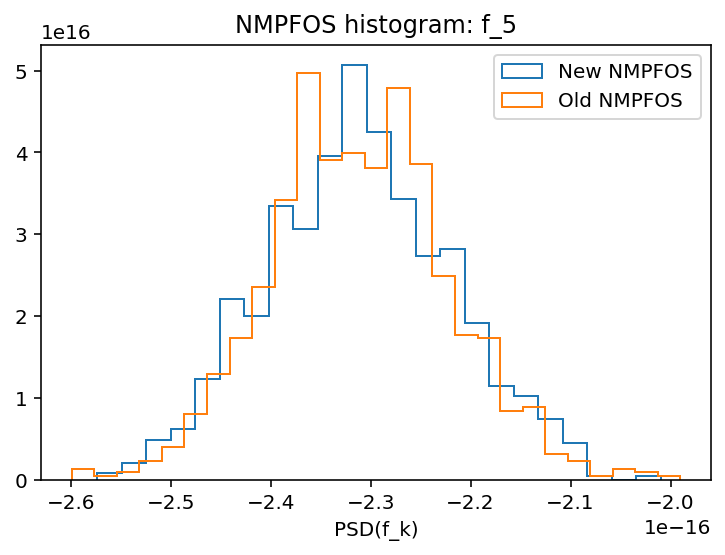

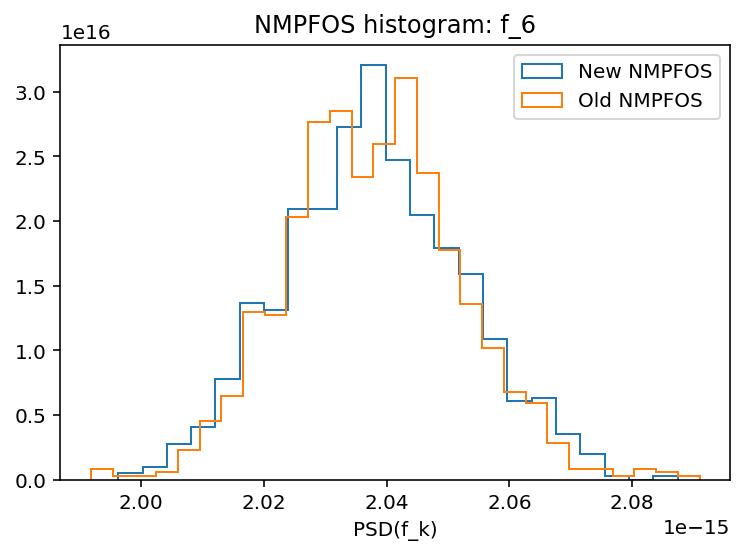

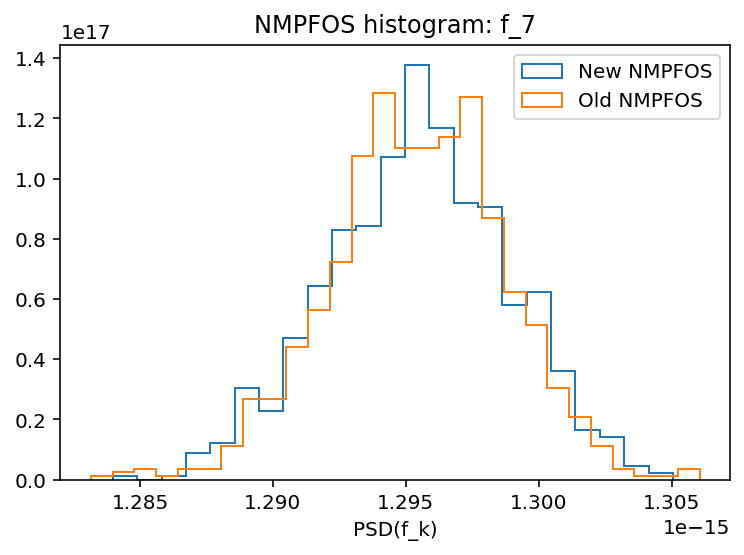

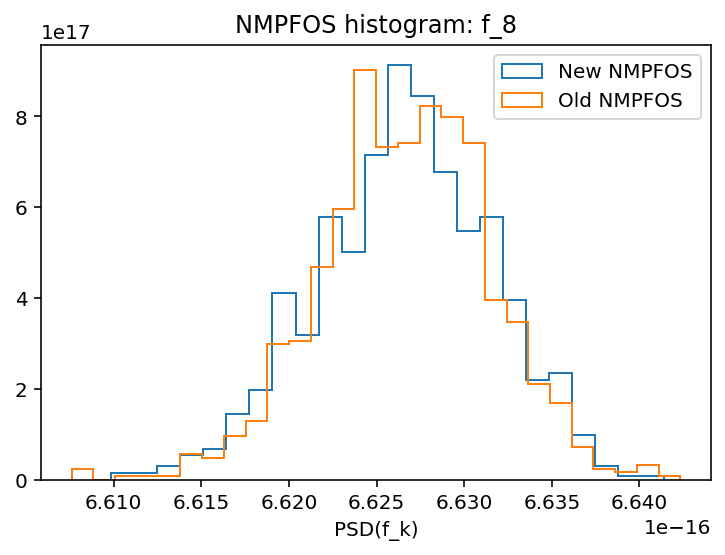

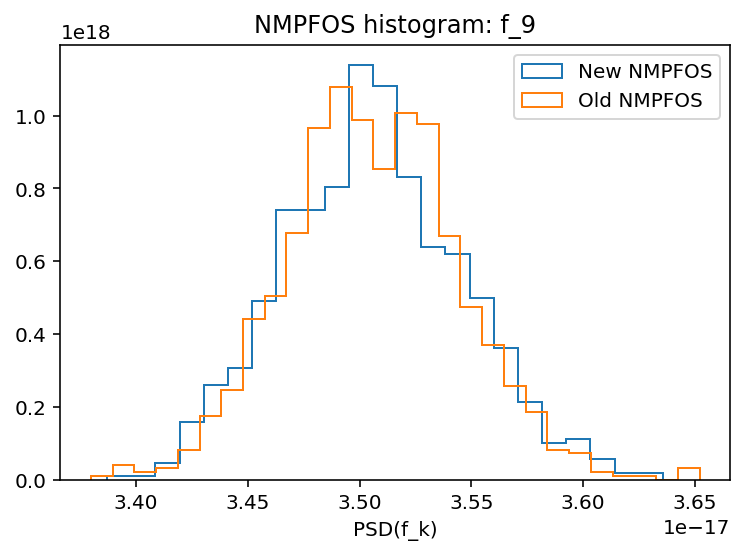

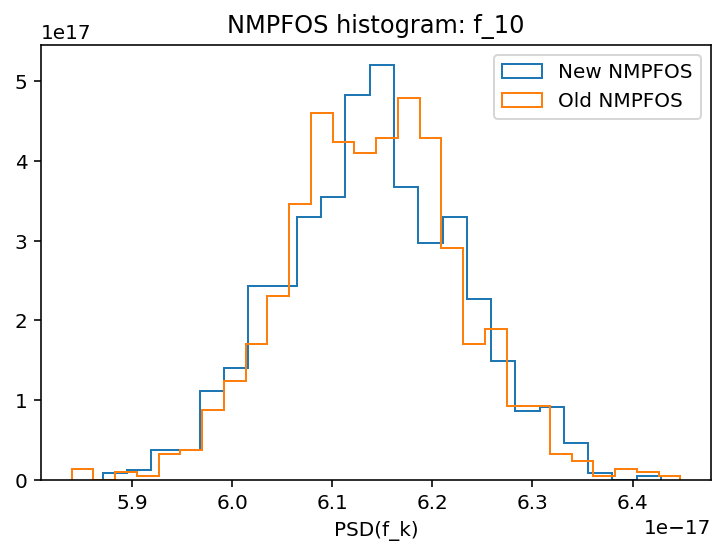

In [16]:
print('min and max percent difference [Sk]:',minmax_percent_diff(old_Sk,Sk))
print('min and max percent difference [Sks]:',minmax_percent_diff(old_Sks,Sks))

for k in range((len(new_os.freqs))):
    inj = powerlaw(new_os.freqs, inj_params['gw_log10_A'], inj_params['gw_gamma'],1)[k]

    plt.hist(old_Sk[:,k],bins='auto',histtype='step',density=True,label='New NMPFOS')
    plt.hist(Sk[:,k],bins='auto',histtype='step',density=True,label='Old NMPFOS')
    #plt.axvline(inj,linestyle='dashed',color='r')
    plt.xlabel('PSD(f_k)')
    plt.title(f'NMPFOS histogram: f_{k+1}')
    plt.legend()
    plt.show()


### I'm convinced this new package works as intended!